# # Run level 2A, 2B and 3 steps on MRS data using jwst step classes

### by Patrick Kavanagh (DIAS, Ireland) July 5th 2018

This notebook demonstrates the execution of the level 2A, 2B, and 3 pipeline steps for MRS data in Python using the jwst step classes.

For a description of the step classes see:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/package_index.html

The files used in this notebook is a MIRISim simulation of a point source with power-law (alpha=0) plus emission lines spectrum. The simulated observation is a four-point dither on the source with the channels 1 and 2, and the SHORT disperser. 

We will run through the level 2A and 2B pipeline steps on one file only, bringing the remaining files to level 2B using the pipeline classes before running level 3 steps. We will save the output of each step to file so the user can have a look if they want. ### note that this will take up significant hardrive space.

We will pass the output of one step to the next in datamodel form. More information on the datamodels can be found here:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/datamodels/index.html


#### imports

In [1]:
import os, glob, shutil
from subprocess import call

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file, output directory for step outputs:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'MRS_demo_data'
input_dir = 'MRS_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the output directory name
output_dir = input_dir + '_tutorial'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input file. 
Note that ground test data and MIRISim data will differ here. We can distinguish between the two using the 'ORIGIN' header keyword. Converted ground test data will always have 'STScI' as the origin.

Also note that there is currently a problem running MIRISim data step-wise through the pipeline. One must remove some of the extensions. This has been taken care of in the following cell. This issue has been reported to STScI and this notebook will be updated when it is resolved.

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t\t Detector\t nInts\t nGrps\t rdPatt\t subAr\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %d\t %s\t %s\t %s\t %s\t %s" % (identifier,detector,nInts,nGroups,readPatt,subArr,channel,band))
        print("\n\n")
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t Detector\t nInts\t nGrps\t rdPatt\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %d\t %s\t %s\t %s\t %s" % (detector,nInts,nGroups,readPatt,channel,band))
        print("\n\n")
        
    # fits extension table
    hdulist.info()

ID	 Detector	 nInts	 nGrps	 rdPatt	 chan.	 band
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIFUSHORT	 2	 50	 FAST	 12	 SHORT



Filename: MRS_demo_data/det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     110   ()      
  1  SCI           1 ImageHDU        54   (1032, 1024, 50, 2)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 1024, 50, 2)   uint8   
  4  ERR           1 ImageHDU        11   (1032, 1024, 50, 2)   float32   
  5  REFOUT        1 ImageHDU        12   (258, 1024, 50, 2)   float32   
  6  ASDF          1 BinTableHDU     11   5469R x 1C   [B]   


## DQ_INIT step ===================================================
This step creates the PIXELDQ, GROUPDQ and ERR extensions in the ramp file 
which are copied from the calibration file. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/dq_init/index.html


### DQ_INIT: load module and show options

In [4]:
# import the step
from jwst.dq_init import dq_init_step

# print the description and options
print(dq_init_step.DQInitStep.__doc__)
print(dq_init_step.DQInitStep.spec)




    DQInitStep:  Initialize the Data Quality extension from the
    mask reference file.  Also initialize the error extension

    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile define in parent step
    input_dir          = s

### DQ_INIT: run step

In [10]:
# run the dq_init step
dm = dq_init_step.DQInitStep.call(input_files[0], save_results=True, output_use_model=True, 
                                  output_dir=output_dir)


2019-01-31 13:59:52,700 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2019-01-31 13:59:52,791 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('MRS_demo_data/det_image_seq2_MIRIFUSHORT_12SHORTexp1.fits',).
2019-01-31 13:59:52,920 - stpipe.DQInitStep - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0022.fits
2019-01-31 14:00:00,528 - stpipe.DQInitStep - INFO - Saved model in MRS_demo_data_tutorial/det_image_seq2_MIRIFUSHORT_12SHORTexp1_dqinitstep.fits
2019-01-31 14:00:00,529 - stpipe.DQInitStep - INFO - Step DQInitStep done


### DQ_INIT:  output check

1. check the output datamodel to show values in the new extensions, check that some pixels have been assigned new flags from the mask file

In [6]:
# check the calibration step information
print('Check dq_init step information status:')
print(dm.meta.cal_step.dq_init)

# print unique values in the PIXELDQ extension
print("\nDQ flags values in PIXELDQ:")
print(', '.join(map(str, np.unique(dm.pixeldq))))

# print unique values in the GROUPDQ extension
print("\nDQ flags values in GROUPDQ extension:")
print(', '.join(map(str, np.unique(dm.groupdq))))

Check dq_init step information status:
COMPLETE

DQ flags values in PIXELDQ:
0, 2049, 16385, 16777217, 2147484160

DQ flags values in GROUPDQ extension:
0


### DQ_INIT:  output plots

1. plot the science data

2. plot the PIXEL_DQ extension to show which pixels have been flagged

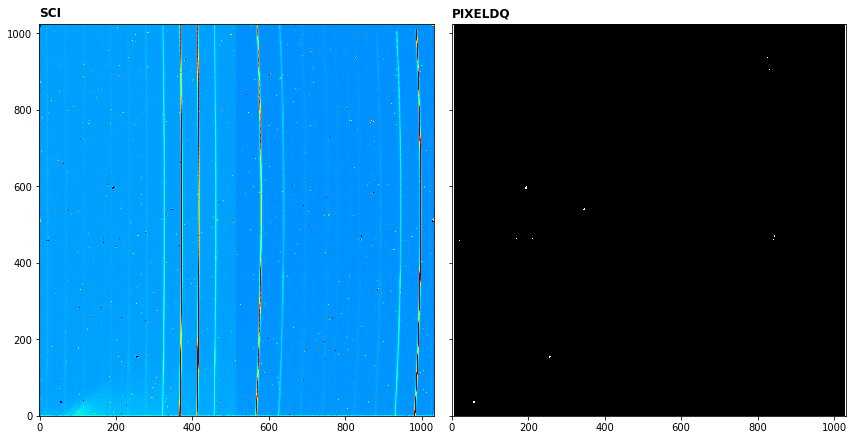

In [12]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# show last frame of first integration
axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', 
              norm=LogNorm(vmin=1e4,vmax=1.5e4))
axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# plot the PIXEL_DQ frame
axs[1].imshow(dm.pixeldq, cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
axs[1].annotate('PIXELDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()
    

## SATURATION step ============================================
The saturation step flags saturated pixel for each integration by reading the calibration reference
file that specifies the saturation level for each pixel. The saturation flags are set in the fram of the GROUPDQ extension where the pixel reaches saturation. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/saturation/index.html


### SATURATION: load module and show options

In [8]:
# import the step
from jwst.saturation import saturation_step

# print the description and options
print(saturation_step.SaturationStep.__doc__)
print(saturation_step.SaturationStep.spec)



    This Step sets saturation flags.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile define in parent step
    input_dir          = string(default=None)        # Input directory
    


### SATURATION: run step

In [13]:
# run the saturation step
dm = saturation_step.SaturationStep.call(dm, save_results=True, output_use_model=True, 
                                         output_dir=output_dir)

2019-01-31 14:00:38,686 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2019-01-31 14:00:38,801 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_dqinitstep.fits>,).
2019-01-31 14:00:38,838 - stpipe.SaturationStep - INFO - Using SATURATION reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0023.fits
2019-01-31 14:00:48,847 - stpipe.SaturationStep - INFO - Saved model in MRS_demo_data_tutorial/det_image_seq2_MIRIFUSHORT_12SHORTexp1_saturationstep.fits
2019-01-31 14:00:48,848 - stpipe.SaturationStep - INFO - Step SaturationStep done


### SATURATION:  output check

1. saturated pixels will be flagged in the GROUPDQ extension with the number 2. Check that some pixels in this extension are now flagged as saturated

In [14]:
# check the calibration step information
print('Check saturation step information status:')
print(dm.meta.cal_step.saturation)

# print unique values in the GROUPDQ extension
print("\nDQ flags values in GROUPDQ extension:")
print(', '.join(map(str, np.unique(dm.groupdq))))
    

Check saturation step information status:
COMPLETE

DQ flags values in GROUPDQ extension:
0


### SATURATION:  output plots

1. plot the science data

2. plot the GROUP_DQ extension to show which pixels have been flagged as saturated (will be blank if no saturated pixels)

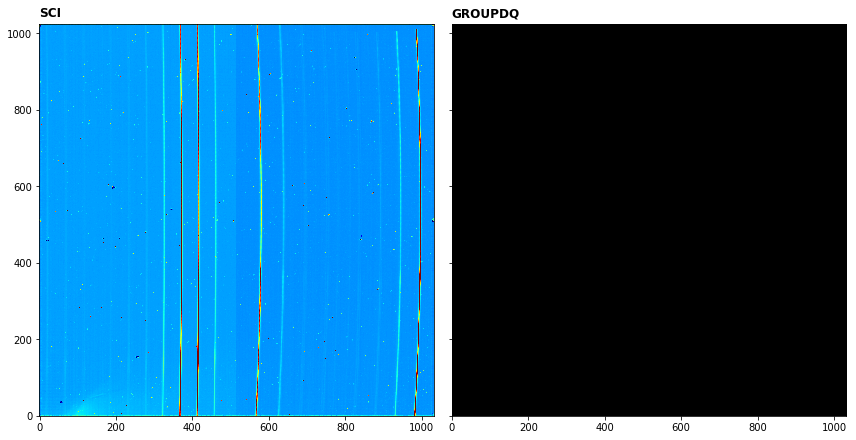

In [16]:
# plot--------------------------------------   
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# show last frame of first integration
axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', 
              norm=LogNorm(vmin=1e4,vmax=1.5e4))
axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

# plot last frame of first integration GROUP_DQ
axs[1].imshow(np.sum(dm.groupdq[0],axis=0), cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
axs[1].annotate('GROUPDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()
    

## LINEARITY step ===============================================

This step corrects for detector non-linearity. The linearity coefficients are read from the linearity correction reference file.

https://jwst-pipeline.readthedocs.io/en/latest/jwst/linearity/index.html


### LINEARITY: load module and show options

In [17]:
# import the step
from jwst.linearity import linearity_step

# print the description and options
print(linearity_step.LinearityStep.__doc__)
print(linearity_step.LinearityStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    LinearityStep: This step performs a correction for non-linear
    detector response, using the "classic" polynomial method.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile define in parent step
    input_dir          = s

### LINEARITY: run step

In [18]:
# run the linearity step
dm = linearity_step.LinearityStep.call(dm, save_results=True, output_use_model=True, 
                                       output_dir=output_dir)


2019-01-31 14:01:29,805 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2019-01-31 14:01:29,892 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_saturationstep.fits>,).
2019-01-31 14:01:29,927 - stpipe.LinearityStep - INFO - Using Linearity reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0023.fits
2019-01-31 14:01:39,932 - stpipe.LinearityStep - INFO - Saved model in MRS_demo_data_tutorial/det_image_seq2_MIRIFUSHORT_12SHORTexp1_linearitystep.fits
2019-01-31 14:01:39,933 - stpipe.LinearityStep - INFO - Step LinearityStep done


### LINEARITY:  plot output science image to select pixel for inspection

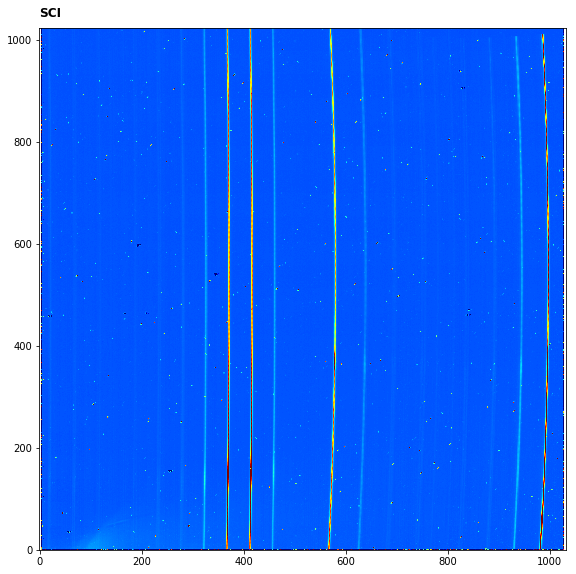

In [21]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', 
           norm=LogNorm(vmin=1e4,vmax=1.5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### LINEARITY:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these

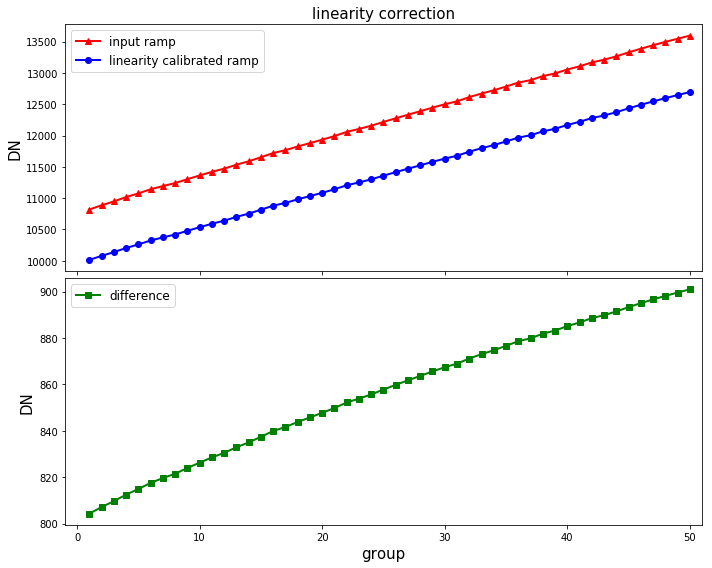

In [23]:
# using image in previous cell, select pixel to check
pixel = [371,600]

# define group numbers for integration ramps
group = range(1,in_dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the first integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, 
            linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', 
            linestyle='-', linewidth=2, label='linearity calibrated ramp')
axs[0].set_title('linearity correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], 
            c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()



## RSCD step ======================================================
This step corrects for the slow adjustment of the reset FET to the asymtotic level after reset. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/rscd/index.html


### RSCD: load module and show options

In [24]:
# import the step
from jwst.rscd import rscd_step

# print the description and options
print(rscd_step.RSCD_Step.__doc__)
print(rscd_step.RSCD_Step.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    RSCD_Step: Performs an RSCD correction to MIRI data by adding a function
    of time, frame by frame, to a copy of the input science data model.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile define in parent step
    i

#### RSCD: run step

In [25]:
# run the rscd step
dm = rscd_step.RSCD_Step.call(dm, save_results=True, output_use_model=True, 
                              output_dir=output_dir)


2019-01-31 14:02:31,033 - stpipe.RSCD_Step - INFO - RSCD_Step instance created.
2019-01-31 14:02:31,107 - stpipe.RSCD_Step - INFO - Step RSCD_Step running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_linearitystep.fits>,).
2019-01-31 14:02:31,142 - stpipe.RSCD_Step - INFO - Using RSCD reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0007.fits
2019-01-31 14:03:47,362 - stpipe.RSCD_Step - INFO - Saved model in MRS_demo_data_tutorial/det_image_seq2_MIRIFUSHORT_12SHORTexp1_rscd_step.fits
2019-01-31 14:03:47,364 - stpipe.RSCD_Step - INFO - Step RSCD_Step done


### RSCD:  plot output science image to select pixel for inspection

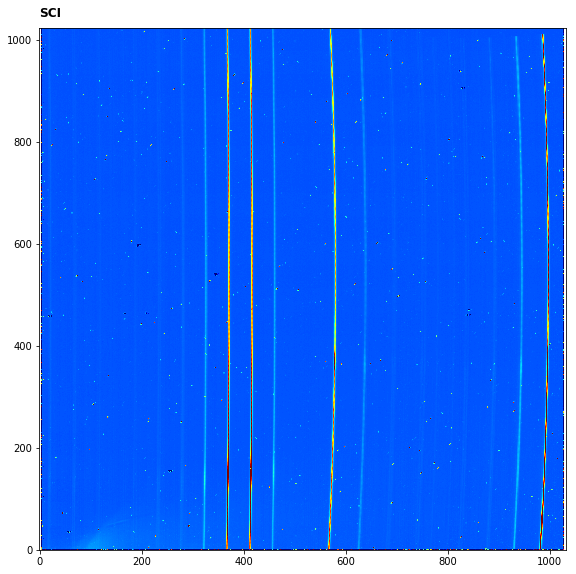

In [26]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', 
           norm=LogNorm(vmin=1e4,vmax=1.5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### RSCD:  input/output ramp comparison

1. plot the input and output ramps. Note that the RSCD step only corrects following a reset show will note perform a correction if there is only one integration in the exposure.

2. show the difference between the input and output ramps


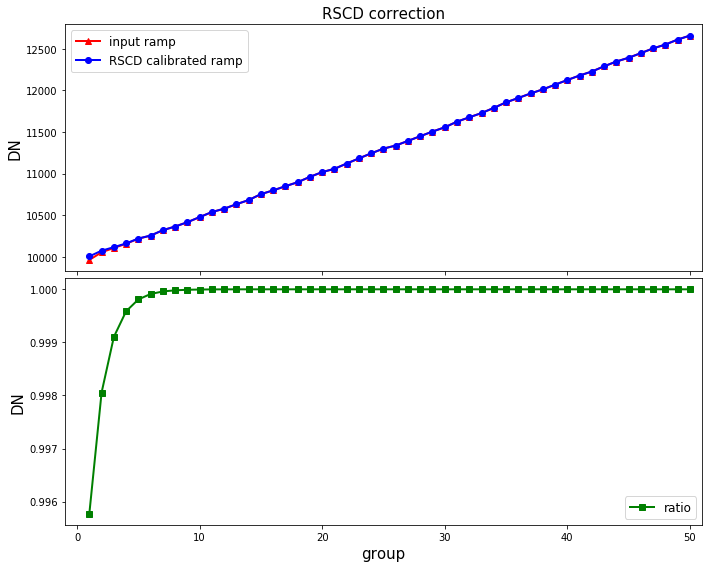

In [27]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

   
# first check that there is more than one integration
if in_dm.data.shape[0] > 1:

    # plot--------------------------------------
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # plot input and output ramps of the second integration
    axs[0].plot(group, in_dm.data[-1,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, 
                linestyle='-', linewidth=2, label='input ramp')
    axs[0].plot(group, dm.data[-1,:,pixel[1],pixel[0]], c='b', marker='o', 
                linestyle='-', linewidth=2, label='RSCD calibrated ramp')
    axs[0].set_title('RSCD correction',fontsize=15)
    axs[0].set_ylabel('DN',fontsize=15)
    axs[0].set_xlim(-1,max(group)+1)
    axs[0].legend(prop={'size':12}, loc=0)

    # plot ratio between the two
    axs[1].plot(group, in_dm.data[-1,:,pixel[1],pixel[0]] / dm.data[-1,:,pixel[1],pixel[0]], 
                c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='ratio')
    axs[1].set_ylabel('DN',fontsize=15)
    axs[1].set_xlabel('group',fontsize=15)
    axs[1].legend(prop={'size':12}, loc=0)

    plt.tight_layout(h_pad=0)
    plt.show()

else: print("RSCD step only operates on exposures with more than one integration.")


## FIRSTFRAME step ==========================================
This step flags the first frame of an integration. The fits frame is not considered later in ramp-fitting See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/firstframe/index.html


### FIRSTFRAME: load module and show options

In [28]:
# import the step
from jwst.firstframe import firstframe_step

# print the description and options
print(firstframe_step.FirstFrameStep.__doc__)
print(firstframe_step.FirstFrameStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    FirstFrameStep: This is a MIRI specific task.  If the number of groups
    is greater than 3, the DO_NOT_USE group data quality flag is added to 
    first group.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile define in

### FIRSTFRAME: run step

In [29]:
# run the firstframe step
dm = firstframe_step.FirstFrameStep.call(dm, save_results=True, output_use_model=True, 
                                         output_dir=output_dir)
                                         

2019-01-31 14:07:23,159 - stpipe.FirstFrameStep - INFO - FirstFrameStep instance created.
2019-01-31 14:07:23,234 - stpipe.FirstFrameStep - INFO - Step FirstFrameStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rscd_step.fits>,).
2019-01-31 14:07:31,164 - stpipe.FirstFrameStep - INFO - Saved model in MRS_demo_data_tutorial/det_image_seq2_MIRIFUSHORT_12SHORTexp1_firstframestep.fits
2019-01-31 14:07:31,166 - stpipe.FirstFrameStep - INFO - Step FirstFrameStep done


### FIRSTFRAME:  input/output ramp comparison

This correction flags the first frame of an integration so we can check that the last frame has indeed been flagged in the groupDQ extension.

1. plot the first frame of the first integration of the GROUPDQ extension, show values of flags (should be solid colour)

2. plot the input and output GROUPDQ to show that last frame has been flagged

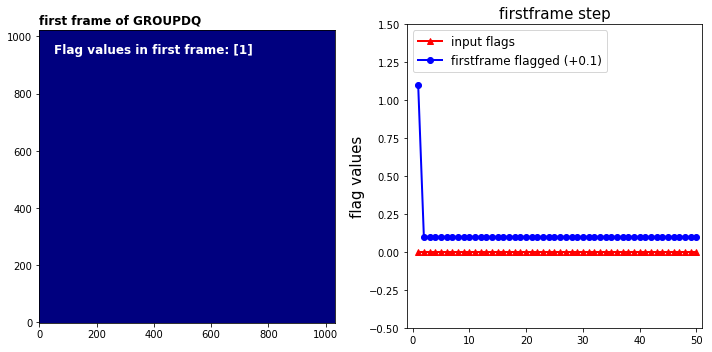

In [30]:
# define an input and output integration ramp for a given pixel
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the first frame of the first integration of the GROUPDQ extension
axs[0].imshow(dm.groupdq[-1][-1], cmap='jet', interpolation='nearest', origin='lower')
axs[0].annotate('first frame of GROUPDQ', xy=(0.0, 1.02), xycoords='axes fraction', 
                fontsize=12, fontweight='bold', color='k')

# determine the values in this GROUPDQ frame
flag_values = np.unique(dm.groupdq[0][0])
axs[0].annotate('Flag values in first frame: %s' % flag_values, xy=(0.05, 0.92), 
                xycoords='axes fraction', fontsize=12, fontweight='bold', color='w')

# input and output ramps (setting a slight offset for the output ramp)
axs[1].plot(group, in_dm.groupdq[-1,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, 
            linestyle='-', linewidth=2, label='input flags')
axs[1].plot(group, dm.groupdq[-1,:,pixel[1],pixel[0]]+0.1, c='b', marker='o', linestyle='-', 
            linewidth=2, label='firstframe flagged (+0.1)')
axs[1].set_title('firstframe step',fontsize=15)
axs[1].set_ylabel('flag values',fontsize=15)
axs[1].set_xlim(-1,max(group)+1)
axs[1].set_ylim(-0.5,1.5)
axs[1].legend(prop={'size':12}, loc=2)

plt.tight_layout(h_pad=0)
plt.show()


## LASTFRAME step ==========================================
This step flags the last frame of an integration. The last frame is not considered later in ramp-fitting See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/lastframe/index.html


### LASTFRAME: load module and show options

In [31]:
# import the step
from jwst.lastframe import lastframe_step

# print the description and options
print(lastframe_step.LastFrameStep.__doc__)
print(lastframe_step.LastFrameStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    LastFrameStep: This is a MIRI specific task.  If the number of groups
    is greater than 2, the GROUP data quality flags for the final group will
    be set to DO_NOT_USE.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile

### LASTFRAME: run step

In [32]:
# run the lastframe step
dm = lastframe_step.LastFrameStep.call(dm, save_results=True, output_use_model=True, 
                                       output_dir=output_dir)


2019-01-31 14:07:54,897 - stpipe.LastFrameStep - INFO - LastFrameStep instance created.
2019-01-31 14:07:54,959 - stpipe.LastFrameStep - INFO - Step LastFrameStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_firstframestep.fits>,).
2019-01-31 14:08:27,939 - stpipe.LastFrameStep - INFO - Saved model in MRS_demo_data_tutorial/det_image_seq2_MIRIFUSHORT_12SHORTexp1_lastframestep.fits
2019-01-31 14:08:27,940 - stpipe.LastFrameStep - INFO - Step LastFrameStep done


### LASTFRAME:  input/output ramp comparison

This correction flags the last frame of an integration so we can check that the last frame has indeed been flagged in the groupDQ extension.

1. plot the last frame of the first integration of the GROUPDQ extension, show values of flags (should be solid colour)

2. plot the input and output GROUPDQ to show that last frame has been flagged

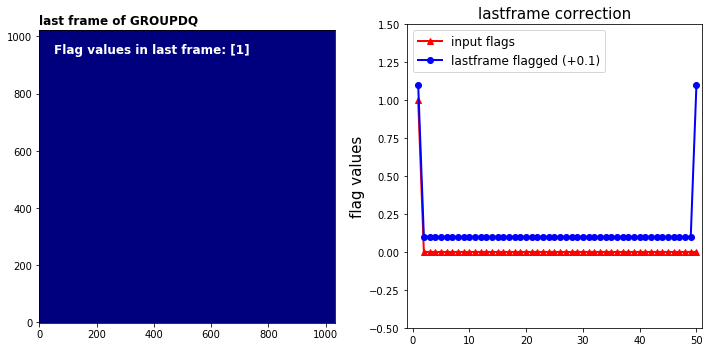

In [33]:
# define an input and output integration ramp for a given pixel
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the last frame of the first integration of the GROUPDQ extension
axs[0].imshow(dm.groupdq[-1][-1], cmap='jet', interpolation='nearest', origin='lower')
axs[0].annotate('last frame of GROUPDQ', xy=(0.0, 1.02), xycoords='axes fraction', 
                fontsize=12, fontweight='bold', color='k')

# determine the values in this GROUPDQ frame
flag_values = np.unique(dm.groupdq[-1][-1])
axs[0].annotate('Flag values in last frame: %s' % flag_values, xy=(0.05, 0.92), xycoords='axes fraction', 
                fontsize=12, fontweight='bold', color='w')

# input and output ramps (setting a slight offset for the output ramp)
axs[1].plot(group, in_dm.groupdq[-1,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, 
            linestyle='-', linewidth=2, label='input flags')
axs[1].plot(group, dm.groupdq[-1,:,pixel[1],pixel[0]]+0.1, c='b', marker='o', 
            linestyle='-', linewidth=2, label='lastframe flagged (+0.1)')
axs[1].set_title('lastframe correction',fontsize=15)
axs[1].set_ylabel('flag values',fontsize=15)
axs[1].set_xlim(-1,max(group)+1)
axs[1].set_ylim(-0.5,1.5)
axs[1].legend(prop={'size':12}, loc=2)

plt.tight_layout(h_pad=0)
plt.show()



## DARK_CURRENT step ==========================================

This step removes the dark current by subtracting a dark current reference file.

https://jwst-pipeline.readthedocs.io/en/latest/jwst/dark_current/index.html

Note that there is only 200 frames in the dark reference file integration. If your data has more than 200 frames per integration, the step will be skipped.

### DARK_CURRENT: load module and show options

In [34]:
# import the step
from jwst.dark_current import dark_current_step

# print the description and options
print(dark_current_step.DarkCurrentStep.__doc__)
print(dark_current_step.DarkCurrentStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    DarkCurrentStep: Performs dark current correction by subtracting
    dark current reference data from the input science data model.
    

        dark_output = output_file(default = None) # Dark model or averaged dark subtracted
    


### DARK_CURRENT: run step

In [35]:
# run the dark_current step
dm = dark_current_step.DarkCurrentStep.call(dm, save_results=True, output_use_model=True, 
                                            output_dir=output_dir)

2019-01-31 14:08:55,868 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2019-01-31 14:08:55,929 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_lastframestep.fits>,).
2019-01-31 14:08:55,965 - stpipe.DarkCurrentStep - INFO - Using DARK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0056.fits
2019-01-31 14:08:56,247 - stpipe.DarkCurrentStep - INFO - Science data nints=2, ngroups=50, nframes=1, groupgap=0
2019-01-31 14:08:56,248 - stpipe.DarkCurrentStep - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0
2019-01-31 14:09:25,055 - stpipe.DarkCurrentStep - INFO - Saved model in MRS_demo_data_tutorial/det_image_seq2_MIRIFUSHORT_12SHORTexp1_darkcurrentstep.fits
2019-01-31 14:09:25,056 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep done


### DARK_CURRENT:  plot output science image to select pixel for inspection

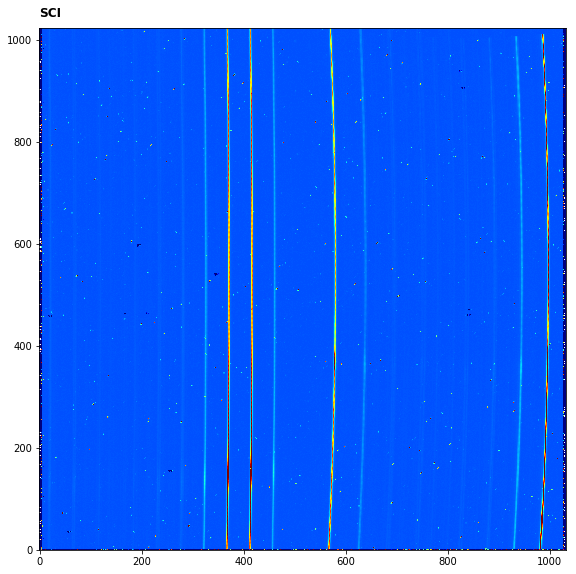

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', 
           norm=LogNorm(vmin=1e4,vmax=1.5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### DARK_CURRENT:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these


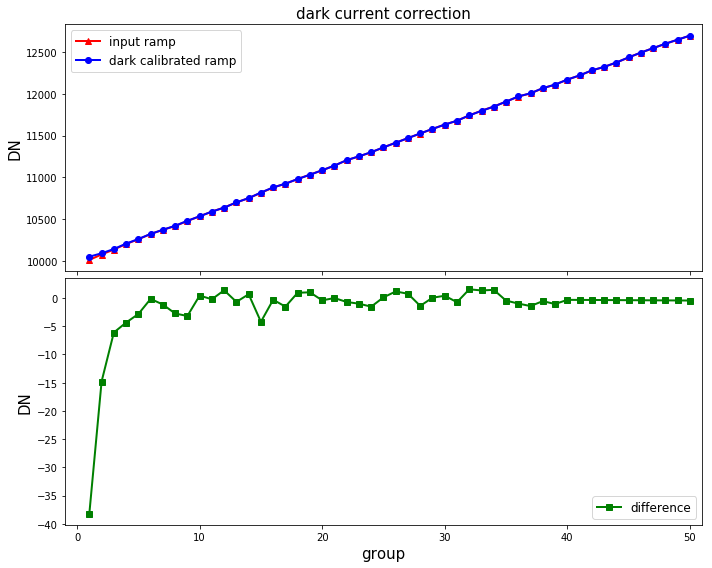

In [37]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the second integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, 
            linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', 
            linestyle='-', linewidth=2, label='dark calibrated ramp')
axs[0].set_title('dark current correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference between the two
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], 
            c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()

## REFPIX step =============================================
This step corrects for electronic drift effects in the data by applying the reference pixel correction. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/refpix/index.html

Note that this should be skipped for MIRISim data for the time being.


### REFPIX: load module and show options

In [38]:
# import the step
from jwst.refpix import refpix_step

# print the description and options
print(refpix_step.RefPixStep.__doc__)
print(refpix_step.RefPixStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()



    RefPixStep: Use reference pixels to correct bias drifts

    

        odd_even_columns = boolean(default=True)
        use_side_ref_pixels = boolean(default=True)
        side_smoothing_length = integer(default=11)
        side_gain = float(default=1.0)
        odd_even_rows = boolean(default=True)
    


### REFPIX: run step

In [39]:
# run the refpix step
dm = refpix_step.RefPixStep.call(dm, save_results=True, output_use_model=True, 
                                 output_dir=output_dir, skip=True)


2019-01-31 14:11:07,292 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2019-01-31 14:11:07,384 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_darkcurrentstep.fits>,).
2019-01-31 14:11:07,385 - stpipe.RefPixStep - INFO - Step skipped.
2019-01-31 14:11:07,386 - stpipe.RefPixStep - INFO - Step RefPixStep done


### REFPIX:  plot output science image to select pixel for inspection

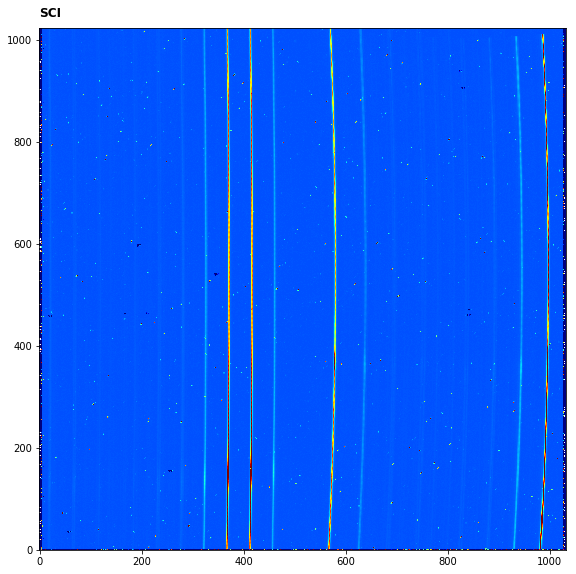

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=1.5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### REFPIX:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these


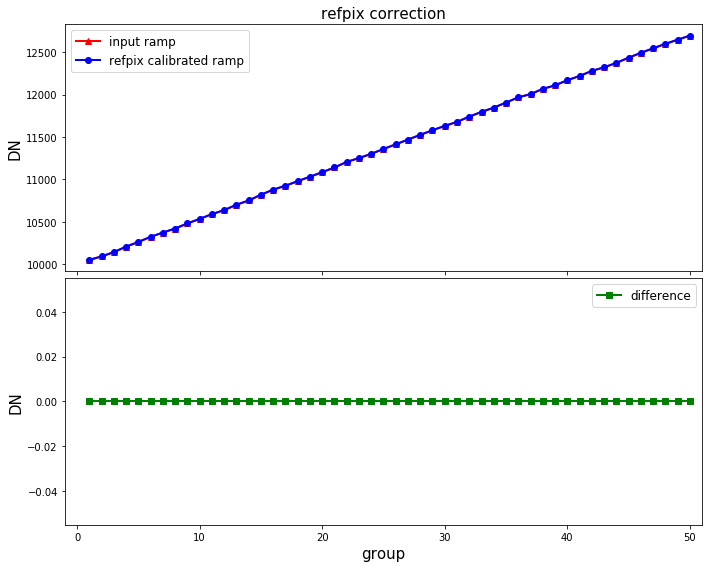

In [41]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]


# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot input and output ramps of the second integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='refpix calibrated ramp')
axs[0].set_title('refpix correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference between the two
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()

## JUMP detection =================================================

This step detects jumps in the ramp by looking for outliers from the ramp. It updates the GROUPDQ array to indicate where a jump was found.

https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/index.html


### JUMP: load module and show options

In [42]:
# import the step
from jwst.jump import jump_step

# print the description and options
print(jump_step.JumpStep.__doc__)
print(jump_step.JumpStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    JumpStep: Performs CR/jump detection on each ramp integration within an
    exposure. The 2-point difference method is applied.
    

        rejection_threshold = float(default=4.0,min=0) # CR rejection threshold
    


### JUMP: run step

In [43]:
# run the jump step
dm = jump_step.JumpStep.call(dm, save_results=True, output_use_model=True, 
                                 output_dir=output_dir)


2019-01-31 16:15:25,164 - stpipe.JumpStep - INFO - JumpStep instance created.
2019-01-31 16:15:25,304 - stpipe.JumpStep - INFO - Step JumpStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_darkcurrentstep.fits>,).
2019-01-31 16:15:25,358 - stpipe.JumpStep - INFO - CR rejection threshold = 4 sigma
2019-01-31 16:15:25,365 - stpipe.JumpStep - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2019-01-31 16:15:25,423 - stpipe.JumpStep - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2019-01-31 16:15:27,036 - stpipe.JumpStep - INFO - Executing two-point difference method
2019-01-31 16:15:27,659 - stpipe.JumpStep - INFO -  working on integration 1
2019-01-31 16:15:31,085 - stpipe.JumpStep - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/jump/twopo

### JUMP:  plot output science image to select pixel for inspection

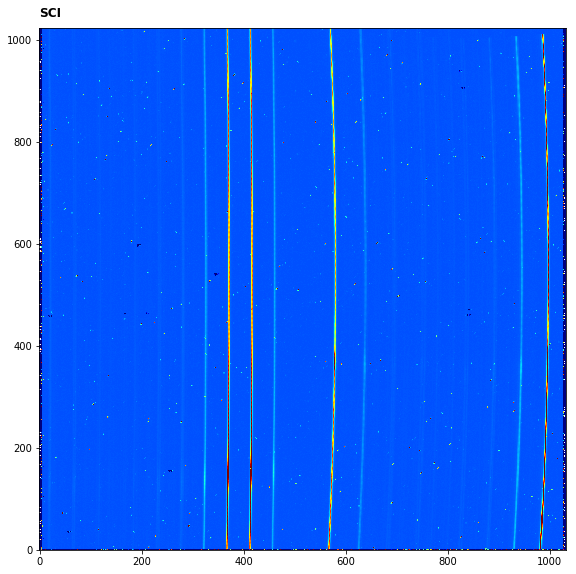

In [44]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', 
           norm=LogNorm(vmin=1e4,vmax=1.5e4))
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### JUMP:  input/output ramp comparison

1. plot the output ramp

2. show the input and output GROUPDQ vectors and mark where jumps were detected (a flag of >=4 in GROUPDQ). It's possible that no jumps are detected.


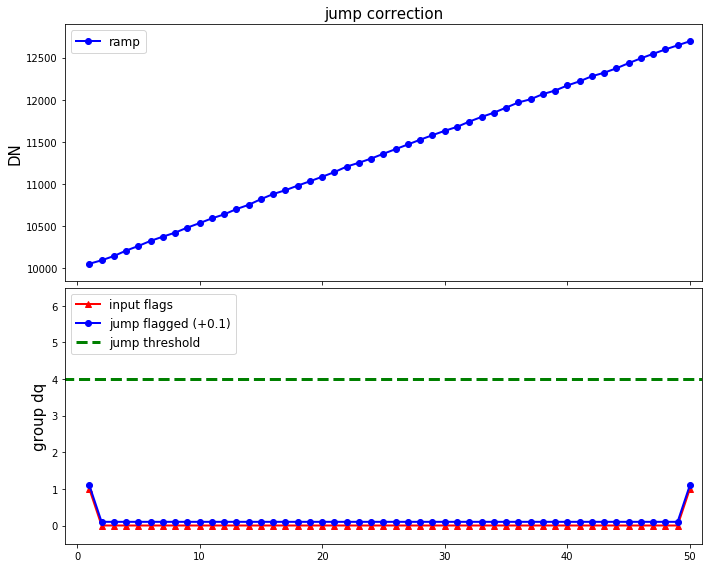

In [45]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# plot--------------------------------------
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# first integration for input/output ramps
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='ramp')
axs[0].set_title('jump correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].set_ylim(min(dm.data[0,:,pixel[1],pixel[0]])-200,max(dm.data[0,:,pixel[1],pixel[0]])+200)
axs[0].legend(prop={'size':12}, loc=2)

# input and output flag values (setting a slight offset for the output flags)
axs[1].plot(group, in_dm.groupdq[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=6, 
            linestyle='-', linewidth=2, label='input flags')
axs[1].plot(group, dm.groupdq[0,:,pixel[1],pixel[0]]+0.1, c='b', marker='o', 
            linestyle='-', linewidth=2, label='jump flagged (+0.1)')
axs[1].plot([-10,100],[4,4], linestyle='--', linewidth=3, c='g', label='jump threshold')
axs[1].set_ylabel('flag values',fontsize=15)
axs[1].set_ylabel('group dq',fontsize=15)
axs[1].set_xlim(-1,max(group)+1)
axs[1].set_ylim(-0.5,6.5)
axs[1].legend(prop={'size':12}, loc=2)

# draw lines to show the groups which have been flagged as jumps
for n, val in enumerate(group):
    if (dm.groupdq[0,n,pixel[1],pixel[0]] >= 4): 
        axs[0].plot([n+1,n+1],[min(dm.data[0,:,pixel[1],pixel[0]])-200,max(dm.data[0,:,pixel[1],pixel[0]])+200], 
                    linestyle='--', linewidth=0.3, c='k')
        axs[1].plot([n+1,n+1],[-1,6], linestyle='--', linewidth=0.3, c='k')

plt.tight_layout(h_pad=0)
plt.show()


## RAMP_FITTING step =========================================

This step caculates the mean count rate for each pixel by performing a linear fit to the ramps. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/ramp_fitting/index.html

There are two outputs are here:

1) the slope image  (_rate.fits)

2) if more than one integration, slope image per integration  (_rateints.fits)

Typically, _rateints.fits is only used for time series observations.

### RAMP_FITTING: load module and show options

In [46]:
# import the step
from jwst.ramp_fitting import ramp_fit_step

# print the description and options
print(ramp_fit_step.RampFitStep.__doc__)
print(ramp_fit_step.RampFitStep.spec)



    This step fits a straight line to the value of counts vs. time to
    determine the mean count rate for each pixel.
    

        int_name = string(default='')
        save_opt = boolean(default=False) # Save optional output
        opt_name = string(default='')
    


### RAMP_FITTING: run step

In [47]:
# run the ramp_fitting step
dm = ramp_fit_step.RampFitStep.call(dm, save_results=True, output_use_model=True, 
                                    output_dir=output_dir)

# copy datamodel for comparison later
level2A_dm = dm[0].copy()

2019-01-31 16:16:40,807 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2019-01-31 16:16:40,905 - stpipe.RampFitStep - INFO - Step RampFitStep running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_jumpstep.fits>,).
2019-01-31 16:16:40,973 - stpipe.RampFitStep - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2019-01-31 16:16:40,999 - stpipe.RampFitStep - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2019-01-31 16:16:41,022 - stpipe.RampFitStep - INFO - Using algorithm = ols
2019-01-31 16:16:41,024 - stpipe.RampFitStep - INFO - Using weighting = optimal
2019-01-31 16:16:41,029 - stpipe.RampFitStep - INFO - MIRI dataset has all final groups flagged as DO_NOT_USE.
2019-01-31 16:16:41,030 - stpipe.RampFitStep - INFO - Effective integration time per group: 2.77504
2019-01-31 16:21:50,012 - stpipe.

### RAMP_FITTING:  level 1B and level 2A image comparison

Visually compare the input ramp and the output slope image

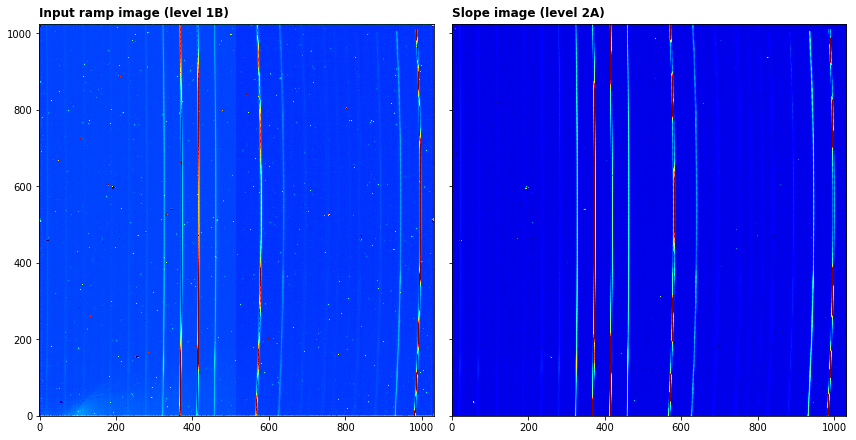

In [50]:
# open the level 1B input as a jwst data model
with datamodels.open(input_files[0]) as in_dm:

    # plot--------------------------------------
    # show the input ramp image and the calibrated
    # slope image.
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    # sum the groups in the first integration of the input ramp image and plot
    axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', 
                  norm=LogNorm(vmin=1e4,vmax=1.5e4))
    axs[0].annotate('Input ramp image (level 1B)', xy=(0.0, 1.02), xycoords='axes fraction',
                    fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(dm[0].data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
    axs[1].annotate('Slope image (level 2A)', xy=(0.0, 1.02), xycoords='axes fraction', 
                    fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()
    

## ASSIGN_WCS step =================================================
This step creates a WCS object and associates it with the science file, mapping detector to world coordinates. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html


In [52]:
# import the step
from jwst.assign_wcs import assign_wcs_step

# print the description and options
print(assign_wcs_step.AssignWcsStep.__doc__)
print(assign_wcs_step.AssignWcsStep.spec)



    AssignWcsStep: Create a gWCS object and store it in ``Model.meta``.

    Reference file types:

    camera             Camera model (NIRSPEC)
    collimator         Collimator Model (NIRSPEC)
    disperser          Disperser model (NIRSPEC)
    distortion         Spatial distortion model (FGS, MIRI, NIRCAM, NIRISS)
    filteroffset       Filter offsets (MIRI Imager)
    fore               Transform through the FORE optics (NIRSPEC)
    fpa                Transform in the FPA plane (NIRSPEC)
    ifufore            Transforms from the MSA plane to the plane of the IFU slicer (NIRSPEC)
    ifupost            Transforms from the slicer plane to the MSA plane (NIRSPEC)
    ifuslicer          Metrology of the IFU slicer (NIRSPEC)
    msa                Metrology of the MSA plane (NIRSPEC)
    ote                Transform through the Optical Telescope Element (NIRSPEC)
    specwcs            Wavelength calibration models (MIRI, NIRCAM, NIRISS)
    regions            Stores location of th

### ASSIGN_WCS: run step

In [53]:
# run the assign_wcs step
dm = assign_wcs_step.AssignWcsStep.call(dm[0], save_results=True, output_use_model=True, 
                                        output_dir=output_dir)


2019-01-31 16:30:57,015 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2019-01-31 16:30:57,382 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rampfitstep.fits>,).
2019-01-31 16:31:09,905 - stpipe.AssignWcsStep - INFO - assign_wcs did not update S_REGION for type MIR_MRS
2019-01-31 16:31:09,906 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2019-01-31 16:31:11,580 - stpipe.AssignWcsStep - INFO - Saved model in MRS_demo_data_tutorial/det_image_seq2_MIRIFUSHORT_12SHORTexp1_assignwcsstep.fits
2019-01-31 16:31:11,581 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


### ASSIGN_WCS:  plot output science image to select pixel for inspection

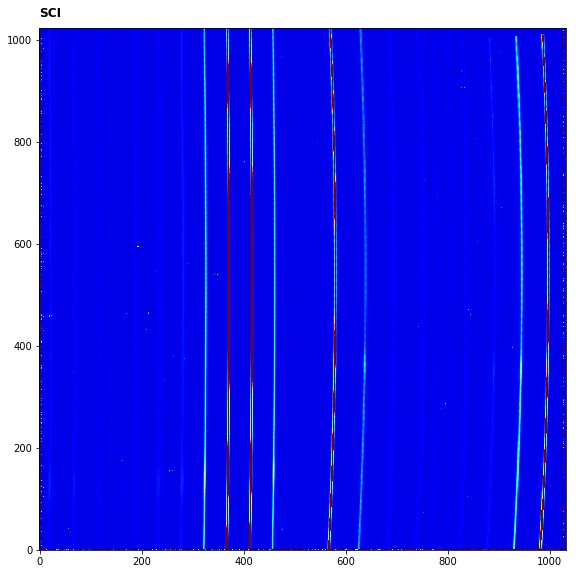

In [54]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

plt.tight_layout()
plt.show()

### ASSIGN_WCS: perform some transforms

1. Display the available coordinate frames

2. perform some transfer from pixel to WCS

In [55]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# print available coordinate frames
print("Available coordinate frames:" )
print(", ".join(dm.meta.wcs.available_frames))
print("")

# perform transforms on pixel
ra, dec, wav = dm.meta.wcs(pixel[0],pixel[1])

print("Pixel: %d, %d" % (pixel[0],pixel[1]))
print("assign_wcs RA, DEC (deg): %0.7f %0.7f" % (ra,dec))
print("assing_wcs Wavelength (micron): %0.3f" % wav)


Available coordinate frames:
detector, alpha_beta, v2v3, world

Pixel: 371, 600
assign_wcs RA, DEC (deg): -0.0000347 -0.0000196
assing_wcs Wavelength (micron): 5.418


## FLAT_FIELD step =============================================
The flat_field step divides the image by a flat-field reference image and updates the DQ array to indicate where no flat-field is available for a pixel. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/index.html


### FLAT_FIELD: load module and show options

In [56]:
# import the step
from jwst.flatfield import flat_field_step

# print the description and options
print(flat_field_step.FlatFieldStep.__doc__)
print(flat_field_step.FlatFieldStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    FlatFieldStep: Flat-field a science image using a flatfield reference image.
    

        # Suffix for optional output file for interpolated flat fields.
        # Note that this is only used for NIRSpec spectrographic data.
        flat_suffix = string(default=None)
    


### FLAT_FIELD: run step

In [57]:
# run the flat_field step
dm = flat_field_step.FlatFieldStep.call(dm, save_results=True, output_use_model=True, 
                                        output_dir=output_dir)


2019-01-31 16:31:13,593 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2019-01-31 16:31:13,752 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_assignwcsstep.fits>,).
2019-01-31 16:31:13,858 - stpipe.FlatFieldStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2019-01-31 16:31:16,338 - stpipe.FlatFieldStep - INFO - Saved model in MRS_demo_data_tutorial/det_image_seq2_MIRIFUSHORT_12SHORTexp1_flatfieldstep.fits
2019-01-31 16:31:16,339 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


### FLAT_FIELD: input/output image checks

1. Display the input and output images
2. Show the ratio of the two

2019-01-31 16:31:16,403 - stpipe - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app

2019-01-31 16:31:16,404 - stpipe - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app



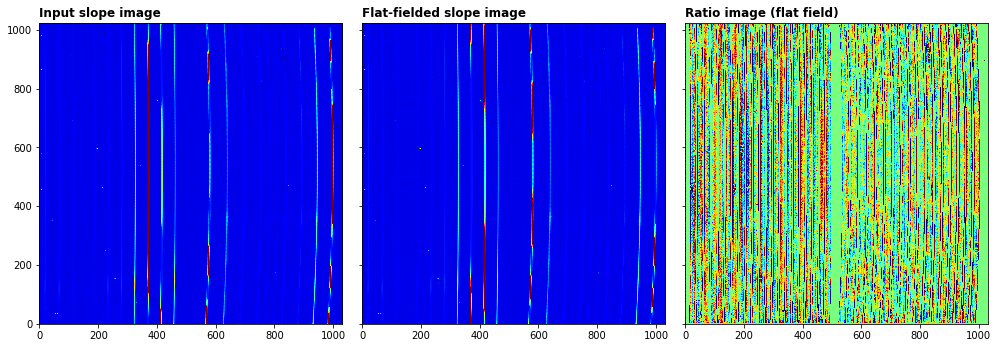

In [58]:
# plot--------------------------------------
# show the input, output and ratio image, 
# which will correspond to the flat field.
fig, axs = plt.subplots(1, 3, figsize=(14, 5),sharey=True)

# show the input
axs[0].imshow(in_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
axs[0].annotate('Input slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')

axs[1].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
axs[1].annotate('Flat-fielded slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

axs[2].imshow(in_dm.data / dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=0.98, vmax=1.02)
axs[2].annotate('Ratio image (flat field)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].set_facecolor('black')

plt.tight_layout()
plt.show()

## SRCTYPE step =======================================
This step checks or sets whether a spectroscopic source should be treated as a point or extended object, writing the appropriate value to a keyword. Allowable values are POINT, EXTENDED and UNKNOWN. This will usually be set from the APT by an observer. If the user sets UNKNOWN, a default of EXTENDED is set for the MRS. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/srctype/index.html


### SRCTYPE: load module and show options

In [59]:
# import the step
from jwst.srctype import srctype_step

# print the description and options
print(srctype_step.SourceTypeStep.__doc__)
print(srctype_step.SourceTypeStep.spec)



    SourceTypeStep: Selects and sets a source type based on various inputs.
    The source type is used in later calibrations to determine the appropriate
    methods to use. Input comes from either the SRCTYPE keyword value, which
    is populated from user info in the APT, or the NIRSpec MSA planning tool.
    

    


### SRCTYPE: run step

In [60]:
# run the srctype step
dm = srctype_step.SourceTypeStep.call(dm, save_results=True, output_use_model=True, 
                                      output_dir=output_dir)

2019-01-31 16:31:16,867 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.
2019-01-31 16:31:17,065 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_flatfieldstep.fits>,).
2019-01-31 16:31:17,099 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is MIR_MRS
2019-01-31 16:31:17,100 - stpipe.SourceTypeStep - INFO - Using input SRCTYPE of POINT
2019-01-31 16:31:18,597 - stpipe.SourceTypeStep - INFO - Saved model in MRS_demo_data_tutorial/det_image_seq2_MIRIFUSHORT_12SHORTexp1_sourcetypestep.fits
2019-01-31 16:31:18,597 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep done


### SRCTYPE: check the SRCTYPE keyword value

In [61]:
# print the value of the srctype keyword
print("SRCTYPE: %s" % dm.meta.target.source_type)
    

SRCTYPE: POINT


 ## STRAYLIGHT step ===========================================

This step performs a straylight correction using a mask file. Straylight has only been detected for MIRI MRS short wavelength channel and only this is corrected. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/straylight/index.html

Note that MIRISim does not simulate straylight so we will skip this step

### STRAYLIGHT: load module and show options

In [62]:
from jwst.straylight import straylight_step

print(straylight_step.StraylightStep.__doc__)
print(straylight_step.StraylightStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    StraylightStep: Performs straylight correction image using a Mask file.
    

         method = option('Nearest','ModShepard',default='ModShepard') #Algorithm method
         roi = float(default = 50.0) # Region of interest
         power = float(default = 1.0) # Power of weighting function

    


### STRAYLIGHT: run step

In [63]:
dm = straylight_step.StraylightStep.call(dm, save_results=True, output_use_model=True, 
                                         output_dir=output_dir, skip=True)

2019-01-31 16:31:19,537 - stpipe.StraylightStep - INFO - StraylightStep instance created.
2019-01-31 16:31:19,635 - stpipe.StraylightStep - INFO - Step StraylightStep running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_sourcetypestep.fits>,).
2019-01-31 16:31:19,636 - stpipe.StraylightStep - INFO - Step skipped.
2019-01-31 16:31:19,638 - stpipe.StraylightStep - INFO - Step StraylightStep done


### STRAYLIGHT: show input, output and difference image (only for SHORT channel)

1. Plot input, output and difference images

In [64]:
if dm.meta.cal_step.straylight == 'COMPLETE':
    # check which channel is used and proceed if SHORT
    if in_dm.meta.instrument.detector == 'MIRIFUSHORT':

        # plot--------------------------------------
        # plot the input and output images and show
        # the difference image
        %matplotlib notebook
        from matplotlib.colors import LogNorm

        fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

        # plot the input image
        axs[0].imshow(in_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
        axs[0].annotate('input SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, 
                        fontweight='bold', color='k')

        # plot the output image
        axs[1].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
        axs[1].annotate('output SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, 
                        fontweight='bold', color='k')

        # look at the difference image
        axs[2].imshow((in_dm.data - dm.data), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=0.01, vmax=100))
        axs[2].annotate('Difference image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, 
                        fontweight='bold', color='k')

        plt.tight_layout()
        plt.show()


    else: print('LONG channel used, straylight step skipped')
else:
    print('Straylight step was skipped')
    

Straylight step was skipped


## FRINGE step ======================================

This step applies a fringe correction to a science image using a fringe reference file. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/fringe/index.html


### FRINGE: load module and show options

In [65]:
from jwst.fringe import fringe_step

print(fringe_step.FringeStep.__doc__)
print(fringe_step.FringeStep.spec)

# copy the datamodel for input/output comparison
in_dm = dm.copy()


    FringeStep: Apply fringe correction to a science image using a fringe
    reference image.
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile define in parent step
    input_dir          = string(default=None)        # Inpu

### FRINGE: run step

In [66]:
dm = fringe_step.FringeStep.call(dm, save_results=True, output_use_model=True, 
                                 output_dir=output_dir)


2019-01-31 16:31:20,570 - stpipe.FringeStep - INFO - FringeStep instance created.
2019-01-31 16:31:20,658 - stpipe.FringeStep - INFO - Step FringeStep running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_sourcetypestep.fits>,).
2019-01-31 16:31:20,694 - stpipe.FringeStep - INFO - Using FRINGE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_fringe_0031.fits
2019-01-31 16:31:20,771 - stpipe.FringeStep - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2019-01-31 16:31:20,773 - stpipe.FringeStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2019-01-31 16:31:20,773 - stpipe.FringeStep - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2019-01-31 16:31:21,770 - stpipe.FringeStep - INFO - The DQ values in the reference file will NOT be used to update the    DQ 

### FRINGE: show input, output and difference image

1. Plot input, output
2. Plot the ratio image

2019-01-31 16:31:23,423 - stpipe - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app

2019-01-31 16:31:23,424 - stpipe - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app



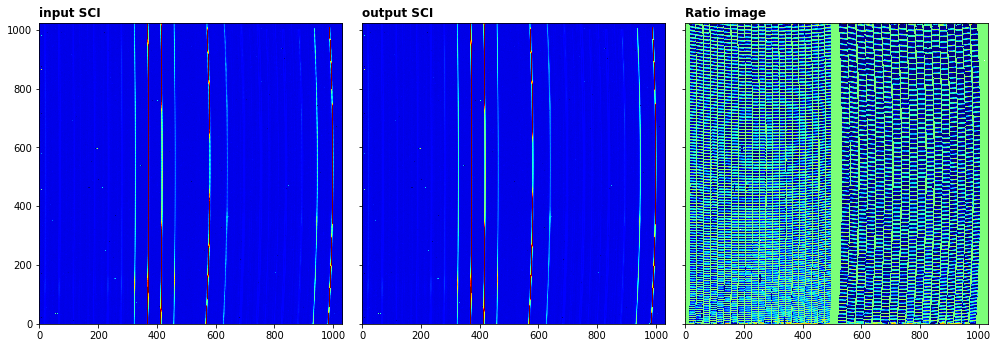

In [67]:
# plot--------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

# plot the input image
axs[0].imshow(in_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
axs[0].annotate('input SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, 
                fontweight='bold', color='k')

# plot the output image
axs[1].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
axs[1].annotate('output SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, 
                fontweight='bold', color='k')

# look at the ratio image
axs[2].imshow((in_dm.data / dm.data), cmap='jet', interpolation='nearest', origin='lower', vmin=0.9, vmax=1.1)
axs[2].annotate('Ratio image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, 
                fontweight='bold', color='k')

plt.tight_layout()
plt.show()


## PHOTOM step =======================================
This step uses spectroscopic photometric conversion reference files to convert count rates to absolute flux units. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/index.html


### PHOTOM: load module and show options

In [68]:
# import the step
from jwst.photom import photom_step

# print the description and options
print(photom_step.PhotomStep.__doc__)
print(photom_step.PhotomStep.spec)



    PhotomStep: Module for loading photometric conversion infomation from
        reference files and attaching or applying them to the input science
        data model
    

    pre_hooks          = string_list(default=list())
    post_hooks         = string_list(default=list())
    output_file        = output_file(default=None)   # File to save output to.
    output_dir         = string(default=None)        # Directory path for output files
    output_ext         = string(default='.fits')     # Default type of output
    output_use_model   = boolean(default=False)      # When saving use `DataModel.meta.filename`
    output_use_index   = boolean(default=True)       # Append index.
    save_results       = boolean(default=False)      # Force save results
    skip               = boolean(default=False)      # Skip this step
    suffix             = string(default=None)        # Default suffix for output files
    search_output_file = boolean(default=True)       # Use outputfile define 

### PHOTOM: run step

In [69]:
dm = photom_step.PhotomStep.call(dm, save_results=True, output_use_model=True, 
                                 output_dir=output_dir)


2019-01-31 16:31:23,928 - stpipe.PhotomStep - INFO - PhotomStep instance created.
2019-01-31 16:31:24,099 - stpipe.PhotomStep - INFO - Step PhotomStep running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_fringestep.fits>,).
2019-01-31 16:31:24,141 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0020.fits
2019-01-31 16:31:24,146 - stpipe.PhotomStep - INFO - Using area reference file: N/A
2019-01-31 16:31:24,147 - stpipe.PhotomStep - INFO - Using instrument: MIRI
2019-01-31 16:31:24,147 - stpipe.PhotomStep - INFO -  detector: MIRIFUSHORT
2019-01-31 16:31:24,149 - stpipe.PhotomStep - INFO -  exp_type: MIR_MRS
2019-01-31 16:31:24,149 - stpipe.PhotomStep - INFO -  band: SHORT
2019-01-31 16:31:24,341 - stpipe.PhotomStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2019-01-31 16:31:26,066 - stpipe.PhotomStep - INFO - Sav

### Review 2A and 2B calibration =======================================

The level 2B file is the calibrated slope product. We can show the evolution of the data through 1B - 2A - 2B stages

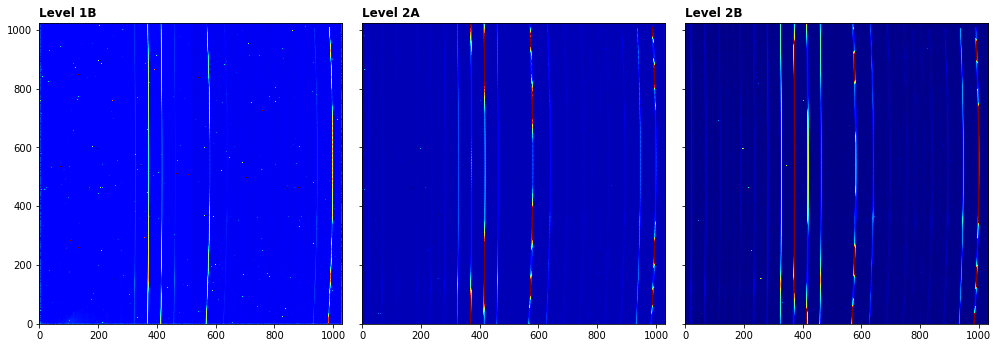

In [70]:
# open the input and output image as jwst data models
with datamodels.open(input_files[0]) as lvl1b_dm:

    # plot--------------------------------------
    # show the input ramp image and the calibrated
    # slope image.
    fig, axs = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

    # 1B image
    axs[0].imshow(lvl1b_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', 
                  norm=LogNorm(vmin=1e4,vmax=2e4))
    axs[0].annotate('Level 1B', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, 
                    fontweight='bold', color='k')
    axs[0].set_facecolor('black')

    # 2A image
    axs[1].imshow(level2A_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=20)
    axs[1].annotate('Level 2A', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, 
                    fontweight='bold', color='k')
    axs[1].set_facecolor('black')

    # 2B image
    axs[2].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=1e2)
    axs[2].annotate('Level 2B', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, 
                    fontweight='bold', color='k')
    axs[2].set_facecolor('black')

    plt.tight_layout()
    plt.show()

## CUBE_BUILD step ======================================
This step builds a cube from the level 2B file See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/cube_build/index.html


### CUBE_BUILD: load module and show options

In [71]:
# import the step
from jwst.cube_build import cube_build_step

# print the description and options
print(cube_build_step.CubeBuildStep.__doc__)
print(cube_build_step.CubeBuildStep.spec)



    CubeBuildStep: Creates a 3-D spectral cube from a given association, single model,
    single input file, or model container.
    Input parameters allow the spectral cube to be built from a provided
    channel/subchannel (MIRI) or grating/filer  (NIRSPEC)
    

         channel = option('1','2','3','4','ALL','all',default='ALL') # Options: 1,2,3,4,or All
         band = option('SHORT','MEDIUM','LONG','ALL','short','medium','long','all',default='ALL') # Options: SHORT,MEDIUM,LONG, or ALL
         grating   = option('PRISM','G140M','G140H','G235M','G235H',G395M','G395H','ALL','all',default='ALL')  # Options: PRISM,G140M,G140H,G235M,G235H,G395M,G395H, or ALL
         filter   = option('CLEAR','F100LP','F070LP','F170LP','F290LP','ALL','all',default='ALL') # Options: CLEAR,F100LP,F070LP,F170LP,F290LP, or ALL
         scale1 = float(default=0.0) # cube sample size to use for axis 1, arc seconds
         scale2 = float(default=0.0) # cube sample size to use for axis 2, arc seconds
     

### CUBE_BUILD: show some observation parameters in case user wants to set options

In [72]:
# show observation parameters
print("detector: %s" % dm.meta.instrument.detector)
print("channel: %s" % dm.meta.instrument.channel)
print("band: %s" % dm.meta.instrument.band)

detector: MIRIFUSHORT
channel: 12
band: SHORT


### CUBE_BUILD: run step
We will select to build a cube from channel 1 only to avoid large gaps in the wavelength direction between channels 1 and 2. 

In [73]:
# run cube_build step
cube_dm = cube_build_step.CubeBuildStep.call(dm, channel='1', band='SHORT', 
                                             save_results=True, output_use_model=True, output_dir=output_dir)


2019-01-31 16:37:10,495 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2019-01-31 16:37:10,616 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_photomstep.fits>,).
2019-01-31 16:37:10,617 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step
2019-01-31 16:37:10,618 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud
2019-01-31 16:37:10,618 - stpipe.CubeBuildStep - INFO - Coordinate system to use: ra-dec
2019-01-31 16:37:10,619 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: msm
2019-01-31 16:37:10,620 - stpipe.CubeBuildStep - INFO - Power Weighting distance : 2.000000
2019-01-31 16:37:10,690 - stpipe.CubeBuildStep - INFO - The desired cubes covers the MIRI Channels: ['1']
2019-01-31 16:37:10,691 - stpipe.CubeBuildStep - INFO - The desired cubes covers the MIRI subchannels: ['SHORT']
2019-01-31 16:37:10,692 - stpipe.CubeBuildStep - INFO - R

### CUBE_BUILD: show output cube

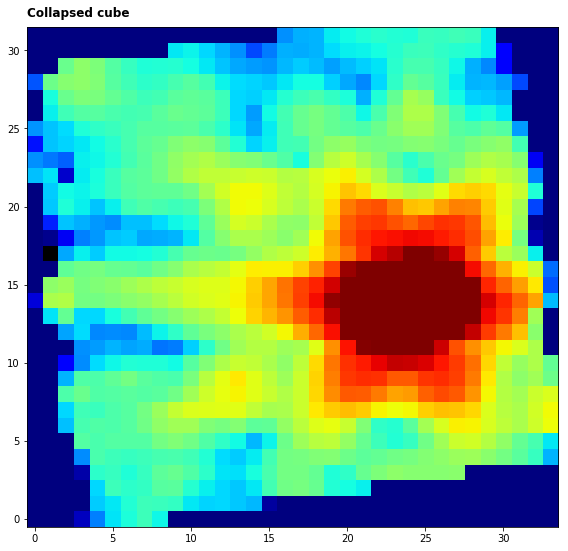

In [74]:
# plot--------------------------------------
# sum the frames of the first integration and plot
# Note the user may have to adjust the scaling
# parameters
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

axs.imshow(np.sum(cube_dm[0].data, axis=0), cmap='jet', interpolation='nearest', origin='lower', 
           norm=LogNorm(vmin=1e1,vmax=1e4))
axs.annotate('Collapsed cube', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, 
             fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()

## EXTRACT_1D step ======================================
This step extracts a 1D spectrum from the cube. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/index.html

Note that since the source_type step above should have set SRCTYPE to 'EXTENDED', the extract_1d step will use an rectangular extraction region with default values. The aperture centre is at pixel x/2, y/2, the width and height are x/2 and y/2, respectively. In the future, more advanced extraction methods are planned. One can set also the aperture properties using a custom aperture reference file. Please contact pkavanagh@cp.dias.ie if you want to do this.

### EXTRACT_1D: load module and show options

In [75]:
# import the step
from jwst.extract_1d import extract_1d_step

# print the description and options
print(extract_1d_step.Extract1dStep.__doc__)
print(extract_1d_step.Extract1dStep.spec)



    Extract1dStep: Extract a 1-d spectrum from 2-d data
    

    # Boxcar smoothing width for background regions.
    smoothing_length = integer(default=None)
    # Order of polynomial fit to one column (or row if the dispersion
    # direction is vertical) of background regions.
    bkg_order = integer(default=None, min=0)
    # Log a progress message when processing multi-integration data.
    log_increment = integer(default=50)
    


### EXTRACT_1D: run step

In [76]:
spec_dm = extract_1d_step.Extract1dStep.call(cube_dm, save_results=True, output_use_model=True, 
                                             output_dir=output_dir)


2019-01-31 16:39:37,531 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2019-01-31 16:39:37,651 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<ModelContainer>,).
2019-01-31 16:39:37,658 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2019-01-31 16:39:37,708 - stpipe.Extract1dStep - INFO - source_type = point
2019-01-31 16:39:40,482 - stpipe.Extract1dStep - INFO - Data have been flux calibrated; setting net to 0.
2019-01-31 16:39:40,560 - stpipe.Extract1dStep - WARNING - INTSTART not found; assuming a value of 1.
2019-01-31 16:39:40,561 - stpipe.Extract1dStep - WARNING - INTEND not found; assuming a value of 2.
2019-01-31 16:39:40,562 - stpipe.Extract1dStep - WARNING - There is no INT_TIMES table in the input file.
2019-01-31 16:39:40,656 - stpipe.Extract1dStep - INFO - Saved model in MRS_demo_data_tutorial/det_image_seq2_MIRIFUSHORT_12SHORTexp1_ph

### EXTRACT_1D: plot spectrum

The extracted spectra are in units of mJy/arcsec^2. To convert these to mJy we multiply by the spaxel area. We also correct for the MIRISim beginning of life transmission factor. Note that an additional correction for the encircled energy in the aperture using the PSF CDP is also required but we forego this here. 

Note that the flux levels are lower than they should be since the centre of the extraction region is not actually located on the source in the cube of a single dither.

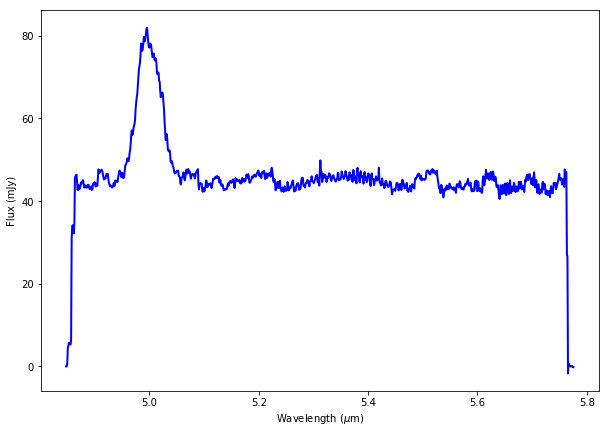

In [77]:
# plot--------------------------------------
# simple XY plot of the spectrum
fig, axs = plt.subplots(1, 1, figsize=(10, 7))

spec = spec_dm.spec[0]

spaxel_area = cube_dm[0].meta.wcsinfo.cdelt1 * cube_dm[0].meta.wcsinfo.cdelt2 * 3600**2
axs.plot(spec.spec_table['WAVELENGTH'], spec.spec_table['FLUX'] * spaxel_area * 1.2, c='b', 
         marker='.', markersize=0, linestyle='-', linewidth=2)
axs.set_ylabel(r'Flux (mJy)')
axs.set_xlabel(r'Wavelength ($\mu$m)')

plt.show()

## BRING DITHERS TO LEVEL 2B FOR LEVEL 3 PROCESSING

In [78]:
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline

for input_file in input_files:
    with datamodels.open(input_file) as dm_1B:
        dm_2A = Detector1Pipeline.call(dm_1B, save_results=True, output_dir=output_dir, output_use_model=True, 
                                   steps={'refpix':{'skip':True}, 'ipc':{'skip':True}})
        dm_2B = Spec2Pipeline.call(dm_2A, save_results=True, output_dir=output_dir, output_use_model=True,
                                   steps={'straylight':{'skip':True},'cube_build':{'save_results':True},
                                          'extract_1d':{'save_results':True}})
        

2019-01-31 16:41:06,545 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2019-01-31 16:41:06,547 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2019-01-31 16:41:06,549 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-01-31 16:41:06,550 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-01-31 16:41:06,552 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-01-31 16:41:06,554 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-01-31 16:41:06,556 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2019-01-31 16:41:06,558 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-01-31 16:41:06,559 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-01-31 16:41:06,561 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2019-01-31 

2019-01-31 16:42:51,329 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2019-01-31 16:42:51,343 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2019-01-31 16:42:51,417 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2019-01-31 16:42:52,836 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2019-01-31 16:42:53,764 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1
2019-01-31 16:42:58,915 - stpipe.Detector1Pipeline.jump - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/jump/twopoint_difference.py:83: RuntimeWarning: invalid value encountered in sqrt
  poisson_noise = np.sqrt(np.abs(med_diffs))

2019-01-31 16:43:15,542 - stpipe.Detector1Pipeline.jump - I

2019-01-31 16:49:42,890 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2019-01-31 16:49:42,891 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2019-01-31 16:49:42,891 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2019-01-31 16:49:42,892 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2019-01-31 16:49:42,893 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0002.fits'.
2019-01-31 16:49:42,894 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2019-01-31 16:49:42,895 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2019-01-31 16:49:42,895 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0021.asdf'.
2019-01-31 16:49:

2019-01-31 16:49:58,509 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2019-01-31 16:49:58,510 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2019-01-31 16:49:58,511 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2019-01-31 16:49:58,512 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: ra-dec
2019-01-31 16:49:58,513 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: msm
2019-01-31 16:49:58,513 - stpipe.Spec2Pipeline.cube_build - INFO - Power Weighting distance : 2.000000
2019-01-31 16:49:58,585 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes covers the MIRI Channels: ['1', '2']
2019-01-31 16:49:58,586 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes covers the MIRI subchannels: ['SHORT', 'SHORT']
2019-01-31 16:49:58,588 - stpipe.Spec2Pipeline.cube_

2019-01-31 16:52:07,728 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits'.
2019-01-31 16:52:07,729 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0007.fits'.
2019-01-31 16:52:07,729 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0023.fits'.
2019-01-31 16:52:07,730 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2019-01-31 16:52:07,731 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2019-01-31 16:52:07,732 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2019-01-31 16:52:07,733 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2019-01-31 16:52:07,86

2019-01-31 16:59:01,950 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/ramp_fit.py:487: RuntimeWarning: divide by zero encountered in true_divide
  slope_dataset2 = s_slope_by_var2/s_inv_var_both2

2019-01-31 16:59:02,308 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/ramp_fit.py:494: RuntimeWarning: divide by zero encountered in true_divide
  slope_int = the_num/the_den

2019-01-31 16:59:02,309 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/ramp_fitting/ramp_fit.py:494: RuntimeWarning: invalid value encountered in true_divide
  slope_int = the_num/the_den

2019-01-31 16:59:02,337 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-p

2019-01-31 17:00:13,470 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0020.fits'.
2019-01-31 17:00:13,471 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_regions_0016.asdf'.
2019-01-31 17:00:13,472 - stpipe.Spec2Pipeline - INFO - Prefetch for RESOL reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_resol_0003.fits'.
2019-01-31 17:00:13,473 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.
2019-01-31 17:00:13,474 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_specwcs_0015.asdf'.
2019-01-31 17:00:13,475 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.
2019-01-31 17:00:13,475 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELE

2019-01-31 17:00:33,509 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1 SHORT 
2019-01-31 17:00:33,510 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2 SHORT 
2019-01-31 17:00:33,511 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name det_image_seq1_MIRIFUSHORT_12SHORTexp1_s3d.fits
2019-01-31 17:02:15,774 - stpipe.Spec2Pipeline.cube_build - INFO - Time Map All slices on Detector to Cube = 92.0.s
2019-01-31 17:02:20,017 - stpipe.Spec2Pipeline.cube_build - INFO - Time to interpolate at spaxel values = 4.2.s
2019-01-31 17:02:20,018 - stpipe.Spec2Pipeline.cube_build - INFO - Time to find Cube Flux= 4.2.s
2019-01-31 17:02:23,243 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done
2019-01-31 17:02:23,776 - stpipe.Spec2Pipeline - INFO - Saved model in MRS_demo_data_tutorial/det_image_seq1_MIRIFUSHORT_12SHORTexp1_s3d.fits
2019-01-31 17:02:24,000 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args

2019-01-31 17:02:43,794 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0023.fits
2019-01-31 17:02:45,439 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2019-01-31 17:02:45,606 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-01-31 17:02:45,653 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0007.fits
2019-01-31 17:03:56,643 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2019-01-31 17:03:56,793 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 50, 1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1.fits>,).
2019-01-31 17:03:57,585 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done
2019-01-31 17

2019-01-31 17:10:24,774 - stpipe.Detector1Pipeline - INFO - Saved model in MRS_demo_data_tutorial/det_image_seq4_MIRIFUSHORT_12SHORTexp1_rateints.fits
2019-01-31 17:10:24,775 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2019-01-31 17:10:25,000 - stpipe.Detector1Pipeline - INFO - Saved model in MRS_demo_data_tutorial/det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits
2019-01-31 17:10:25,001 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2019-01-31 17:10:25,020 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2019-01-31 17:10:25,022 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2019-01-31 17:10:25,024 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2019-01-31 17:10:25,026 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.
2019-01-31 17:10:25,028 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2019-01-31 17:10:25,032 - stpipe.Spec2Pipeline.imprint_su

2019-01-31 17:10:38,621 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2019-01-31 17:10:38,622 - stpipe.Spec2Pipeline.srctype - INFO - Using input SRCTYPE of POINT
2019-01-31 17:10:38,623 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2019-01-31 17:10:38,775 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2019-01-31 17:10:38,776 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.
2019-01-31 17:10:38,777 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done
2019-01-31 17:10:38,924 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<IFUImageModel(1024, 1032) from det_image_seq4_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2019-01-31 17:10:38,959 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_fringe_0031.fits
2019-01-31 17:10:39,030 -

2019-01-31 17:12:43,630 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2019-01-31 17:12:43,631 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2019-01-31 17:12:43,633 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2019-01-31 17:12:43,635 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2019-01-31 17:12:43,637 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2019-01-31 17:12:43,639 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2019-01-31 17:12:43,640 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2019-01-31 17:12:43,642 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2019-01-31 17:12:43,644 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2019-01-31 17:12:43,647 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2019

2019-01-31 17:14:10,676 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2019-01-31 17:14:10,705 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2019-01-31 17:14:11,284 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2019-01-31 17:14:11,810 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 1
2019-01-31 17:14:14,931 - stpipe.Detector1Pipeline.jump - WARNING - /anaconda3/envs/mirisim/lib/python3.5/site-packages/jwst-0.9.6-py3.5-macosx-10.6-x86_64.egg/jwst/jump/twopoint_difference.py:83: RuntimeWarning: invalid value encountered in sqrt
  poisson_noise = np.sqrt(np.abs(med_diffs))

2019-01-31 17:14:28,652 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 2
2019-01-31 17:14:45,155 - stpipe.Detector1Pipeline.jump - INFO - S

2019-01-31 17:20:15,145 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2019-01-31 17:20:15,146 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2019-01-31 17:20:15,146 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2019-01-31 17:20:15,147 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2019-01-31 17:20:15,147 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0002.fits'.
2019-01-31 17:20:15,148 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2019-01-31 17:20:15,149 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2019-01-31 17:20:15,149 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0021.asdf'.
2019-01-31 17:20:

2019-01-31 17:20:30,422 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<IFUImageModel(1024, 1032) from det_image_seq3_MIRIFUSHORT_12SHORTexp1_rate.fits>,).
2019-01-31 17:20:30,424 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2019-01-31 17:20:30,425 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2019-01-31 17:20:30,425 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: ra-dec
2019-01-31 17:20:30,426 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: msm
2019-01-31 17:20:30,427 - stpipe.Spec2Pipeline.cube_build - INFO - Power Weighting distance : 2.000000
2019-01-31 17:20:30,496 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes covers the MIRI Channels: ['1', '2']
2019-01-31 17:20:30,497 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes covers the MIRI subchannels: ['SHORT', 'SHORT']
2019-01-31 17:20:30,498 - stpipe.Spec2Pipeline.cube_

In [97]:
# create and load association
cal_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))
call(["asn_from_list", "-o", "MRS_asn.json"] + cal_files + ["--product-name", "dither"])
dms = datamodels.open("MRS_asn.json")

## MRS_IMATCH step ======================================
This step “matches” image intensities of several input 2D MIRI MRS images by fitting polynomials to cube intensities (cubes built from input 2D images) in such a way as to minimize inter-image mismatch in the least squares sense.  See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/mrs_imatch/index.html

Note that by default this step adds the determined polynomials to each input datamodel metadata but does not subtract them from the image data. This funcitonality must be set by the user with the 'subtract' option.

The subtraction appears to happen in cube_build. Unfortunately, this does not appear to be working very well at the moment so we will skip this step for now.

### MRS_IMATCH: load module and show options

In [80]:
# import the step
from jwst.mrs_imatch import mrs_imatch_step

# print the description and options
print(mrs_imatch_step.MRSIMatchStep.__doc__)
print(mrs_imatch_step.MRSIMatchStep.spec)



    MRSIMatchStep: Subtraction or equalization of sky background in MIRI MRS science images.

    

        # General sky matching parameters:
        bkg_degree = integer(min=0, default=1) # Degree of the polynomial for background fitting
        subtract = boolean(default=False) # subtract computed sky from 'images' cube data?

    


### MRS_IMATCH: run step

In [94]:
dms = mrs_imatch_step.MRSIMatchStep.call(dms, skip=True)


2019-02-01 10:17:12,609 - stpipe.MRSIMatchStep - INFO - MRSIMatchStep instance created.
2019-02-01 10:17:13,007 - stpipe.MRSIMatchStep - INFO - Step MRSIMatchStep running with args (<ModelContainer>,).
2019-02-01 10:17:42,515 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2019-02-01 10:17:42,516 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step
2019-02-01 10:17:42,517 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud
2019-02-01 10:17:42,518 - stpipe.CubeBuildStep - INFO - Coordinate system to use: ra-dec
2019-02-01 10:17:42,518 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: msm
2019-02-01 10:17:42,519 - stpipe.CubeBuildStep - INFO - Power Weighting distance : 2.000000
2019-02-01 10:17:42,735 - stpipe.MRSIMatchStep - INFO - The desired cubes covers the MIRI Channels: ['1']
2019-02-01 10:17:42,736 - stpipe.MRSIMatchStep - INFO - The desired cubes covers the MIRI subchannels: ['SHORT']
2019-02-01 10:17:42,737 - stpipe.MRSIMat

2019-02-01 10:25:30,757 - stpipe.MRSIMatchStep - INFO - Step MRSIMatchStep done


### MRS_IMATCH: check background metadata

1. Check that the determined polynomial info for the first dither only

In [95]:
print(dms[0].meta.filename + ':')
print(dms[0].meta.background.polynomial_info)
    

det_image_seq2_MIRIFUSHORT_12SHORTexp1_mrsimatchstep.fits:
[{'refpoint': (-1.6376430947558577e-05, -7.714131695841923e-06, 4.847613704135425), 'degree': (1, 1, 1), 'channel': '1', 'coefficients': [0.2529508693343559, -0.09265422251665069, -283.44874321044995, 69.86378974006863, -0.0007231915812298881, 0.00045596658900712544, 0.5854433768574536, -0.35524139772019203]}, {'refpoint': (-3.260911443125035e-05, -9.314696877009318e-05, 7.445174730317602), 'degree': (1, 1, 1), 'channel': '2', 'coefficients': [-0.06467528362949398, -0.021214341504164812, -34.783466095382906, -9.261128774084852, 0.0004880838101312369, 6.947401454626364e-05, 0.5557590647832195, 0.011771753499670835]}]


## OUTLIER_DETECTION step ======================================
Flag outlier bad pixels and missed cosmic rays in the DQ array of each input image. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/outlier_detection/index.html


### OUTLIER_DETECTION: load module and show options

In [98]:
# import the step
from jwst.outlier_detection import outlier_detection_step

# print the description and options
print(outlier_detection_step.OutlierDetectionStep.__doc__)
print(outlier_detection_step.OutlierDetectionStep.spec)


Flag outlier bad pixels and cosmic rays in DQ array of each input image.

    Input images can listed in an input association file or already opened
    with a ModelContainer.  DQ arrays are modified in place.

    Parameters
    -----------
    input : asn file or ModelContainer
        Single filename association table, or a datamodels.ModelContainer.

    

        wht_type = option('exptime','error',None,default='exptime')
        pixfrac = float(default=1.0)
        kernel = string(default='square') # drizzle kernel
        fillval = string(default='INDEF')
        nlow = integer(default=0)
        nhigh = integer(default=0)
        maskpt = float(default=0.7)
        grow = integer(default=1)
        snr = string(default='4.0 3.0')
        scale = string(default='0.5 0.4')
        backg = float(default=0.0)
        save_intermediate_results = boolean(default=False)
        resample_data = boolean(default=True)
        good_bits = integer(default=4)
        scale_detection = boole

### OUTLIER_DETECTION: run step

In [99]:
# run step
dms = outlier_detection_step.OutlierDetectionStep.call(dms)


2019-02-01 10:46:57,833 - stpipe.OutlierDetectionStep - INFO - OutlierDetectionStep instance created.
2019-02-01 10:46:58,367 - stpipe.OutlierDetectionStep - INFO - Step OutlierDetectionStep running with args (<ModelContainer>,).
2019-02-01 10:47:06,574 - stpipe.OutlierDetectionStep - INFO - Performing outlier detection on 4 inputs
2019-02-01 10:47:28,825 - stpipe.OutlierDetectionStep - INFO - Performing IFU outlier_detection for exptype MIR_MRS
2019-02-01 10:47:28,828 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2019-02-01 10:47:28,829 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step
2019-02-01 10:47:28,829 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud
2019-02-01 10:47:28,830 - stpipe.CubeBuildStep - INFO - Coordinate system to use: ra-dec
2019-02-01 10:47:28,830 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: msm
2019-02-01 10:47:28,831 - stpipe.CubeBuildStep - INFO - Power Weighting distance : 2.000000
2019-02-01 

## CUBE_BUILD step ======================================
In the level 3 pipeline, this step builds a cube from all level 2B files in the association, i.e., combining the dithers. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/cube_build/index.html


### CUBE_BUILD: load module and show options

In [100]:
from jwst.cube_build import cube_build_step

# print the description and options
print(cube_build_step.CubeBuildStep.__doc__)
print(cube_build_step.CubeBuildStep.spec)



    CubeBuildStep: Creates a 3-D spectral cube from a given association, single model,
    single input file, or model container.
    Input parameters allow the spectral cube to be built from a provided
    channel/subchannel (MIRI) or grating/filer  (NIRSPEC)
    

         channel = option('1','2','3','4','ALL','all',default='ALL') # Options: 1,2,3,4,or All
         band = option('SHORT','MEDIUM','LONG','ALL','short','medium','long','all',default='ALL') # Options: SHORT,MEDIUM,LONG, or ALL
         grating   = option('PRISM','G140M','G140H','G235M','G235H',G395M','G395H','ALL','all',default='ALL')  # Options: PRISM,G140M,G140H,G235M,G235H,G395M,G395H, or ALL
         filter   = option('CLEAR','F100LP','F070LP','F170LP','F290LP','ALL','all',default='ALL') # Options: CLEAR,F100LP,F070LP,F170LP,F290LP, or ALL
         scale1 = float(default=0.0) # cube sample size to use for axis 1, arc seconds
         scale2 = float(default=0.0) # cube sample size to use for axis 2, arc seconds
     

### CUBE_BUILD: run step

In [101]:
# run step
cube_dm = cube_build_step.CubeBuildStep.call(dms, save_results=True, output_dir=output_dir)

2019-02-01 11:02:53,558 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2019-02-01 11:02:54,550 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep running with args (<ModelContainer>,).
2019-02-01 11:02:54,551 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step
2019-02-01 11:02:54,552 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud
2019-02-01 11:02:54,553 - stpipe.CubeBuildStep - INFO - Coordinate system to use: ra-dec
2019-02-01 11:02:54,554 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: msm
2019-02-01 11:02:54,555 - stpipe.CubeBuildStep - INFO - Power Weighting distance : 2.000000
2019-02-01 11:02:54,926 - stpipe.CubeBuildStep - INFO - The desired cubes covers the MIRI Channels: ['1', '2']
2019-02-01 11:02:54,928 - stpipe.CubeBuildStep - INFO - The desired cubes covers the MIRI subchannels: ['SHORT', 'SHORT']
2019-02-01 11:02:54,930 - stpipe.CubeBuildStep - INFO - Reading  cube parameter file /Users/patrickkavanagh/crds_m

### CUBE_BUILD: plot the channels of the cube

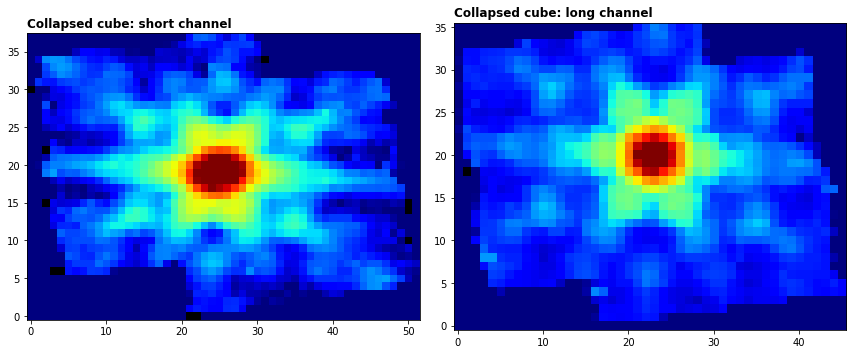

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.sum(cube_dm[0].data[50:-50], axis=0), cmap='jet', interpolation='nearest', origin='lower', 
              norm=LogNorm(vmin=50,vmax=5e4))
axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, 
                fontweight='bold', color='k')
axs[0].set_facecolor('black')
axs[1].imshow(np.sum(cube_dm[1].data[50:-50], axis=0), cmap='jet', interpolation='nearest', origin='lower', 
              norm=LogNorm(vmin=50,vmax=5e4))
axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, 
                fontweight='bold', color='k')
axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()

## EXTRACT_1D step ======================================
In the level 3 pipeline, this step extracts a 1D spectrum from the combined cube. See:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/index.html

As above, since the source_type step above should have set SRCTYPE to 'EXTENDED', the extract_1d step will use an rectangular extraction region with default values. The aperture centre is at pixel x/2, y/2, the width and height are x/2 and y/2, respectively. In the future, more advanced extraction methods are planned. One can set also the aperture properties using a custom aperture reference file. Please contact pkavanagh@cp.dias.ie if you want to do this.

### EXTRACT_1D: load module and show options

In [103]:
from jwst.extract_1d import extract_1d_step

# print the description and options
print(extract_1d_step.Extract1dStep.__doc__)
print(extract_1d_step.Extract1dStep.spec)


    Extract1dStep: Extract a 1-d spectrum from 2-d data
    

    # Boxcar smoothing width for background regions.
    smoothing_length = integer(default=None)
    # Order of polynomial fit to one column (or row if the dispersion
    # direction is vertical) of background regions.
    bkg_order = integer(default=None, min=0)
    # Log a progress message when processing multi-integration data.
    log_increment = integer(default=50)
    


### EXTRACT_1D: run step

In [104]:
# run step
spec_dm = extract_1d_step.Extract1dStep.call(cube_dm, save_results=True, output_use_model=True,
                                             output_dir=output_dir)


2019-02-01 11:07:57,104 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2019-02-01 11:07:57,571 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<ModelContainer>,).
2019-02-01 11:07:57,581 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2019-02-01 11:07:57,616 - stpipe.Extract1dStep - INFO - source_type = point
2019-02-01 11:08:00,194 - stpipe.Extract1dStep - INFO - Data have been flux calibrated; setting net to 0.
2019-02-01 11:08:00,260 - stpipe.Extract1dStep - WARNING - INTSTART not found; assuming a value of 1.
2019-02-01 11:08:00,261 - stpipe.Extract1dStep - WARNING - INTEND not found; assuming a value of 2.
2019-02-01 11:08:00,262 - stpipe.Extract1dStep - WARNING - There is no INT_TIMES table in the input file.
2019-02-01 11:08:00,267 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jw

### EXTRACT_1D: plot spectrum

Again, the extracted spectra are in units of mJy/arcsec^2. To convert these to mJy we multiply by the spaxel area. We also correct for the MIRISim beginning of life transmission factor. Note that an additional correction for the encircled energy in the aperture using the PSF CDP is also required but we forego this here. 

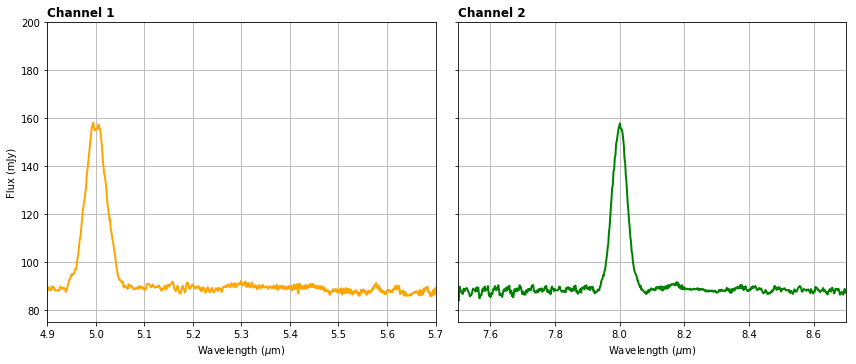

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# plot the spectrum in the channel 2 wavelength range
spaxel_area = cube_dm[0].meta.wcsinfo.cdelt1 * cube_dm[0].meta.wcsinfo.cdelt2 * 3600**2
axs[0].plot(spec_dm[0].spec[0].spec_table['WAVELENGTH'], 
            spec_dm[0].spec[0].spec_table['FLUX'] * spaxel_area, 
            c='orange', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[0].set_ylabel(r'Flux (mJy)')
axs[0].set_xlabel(r'Wavelength ($\mu$m)')
axs[0].set_xlim(4.9,5.7)
axs[0].set_ylim(75,200)
axs[0].annotate('Channel 1', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].grid()
spaxel_area = cube_dm[1].meta.wcsinfo.cdelt1 * cube_dm[1].meta.wcsinfo.cdelt2 * 3600**2
axs[1].plot(spec_dm[1].spec[0].spec_table['WAVELENGTH'], 
            spec_dm[1].spec[0].spec_table['FLUX']  * spaxel_area, 
            c='g', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[1].set_xlabel(r'Wavelength ($\mu$m)')
axs[1].set_xlim(7.5,8.7)
axs[1].annotate('Channel 2', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].grid()

plt.tight_layout()
plt.show()